In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib

In [160]:
log_dir = "../src/controller/logs/kp1-fps500"
event_acc = EventAccumulator(log_dir)
event_acc.Reload()
tags = event_acc.Tags()['scalars']

In [161]:
framesqueued_tag = [t for t in tags if 'framesqueued' in t]
framesprocessed_tag = [t for t in tags if 'framesprocessed' in t]
replica_tag = [t for t in tags if 'replica' in t]

In [162]:
def get_data(writer, tags):
    dfs = []
    for tag in tags:
        s = writer.Scalars(tag)
        temp_df = pd.DataFrame(s)
        temp_df['wall_time'] = pd.to_datetime(temp_df['wall_time'], unit='s')
        temp_df['tag'] = tag
        # Set the wall_time column as the index
        temp_df.set_index('wall_time', inplace=True)
        # Select only numeric columns for resampling
        numeric_df = temp_df.select_dtypes(include=['number'])

        # Resample to 5 seconds and calculate the mean
        df_resampled = numeric_df.resample('5S').max()
        df_resampled["diff"] = df_resampled["value"].diff().fillna(0)

        # Reset the index
        df_resampled.reset_index(inplace=True)
        dfs.append(df_resampled)

    # Concatenate all DataFrames in framesprocessed_dfs and select the 'diff' column
    diff_df = pd.concat([df[['wall_time', 'value', 'diff']] for df in dfs], ignore_index=True)
    diff_df.sort_values(by='wall_time', inplace=True)
    diff_df.set_index('wall_time', inplace=True)
    return diff_df

In [163]:
framesprocessed_df = get_data(event_acc, framesprocessed_tag)
framesqueued_df = get_data(event_acc, framesqueued_tag)
replica_df = get_data(event_acc, replica_tag)

/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = numeric_df.resample('5S').max()
/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = numeric_df.resample('5S').max()
/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = numeric_df.resample('5S').max()
/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = numeric_df.resample('5S').max()
/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = numeric_df.resample('5S').max()
/tmp/ipykernel_1456461/20854210.py:14: FutureWarning: 'S' is deprecate

In [164]:
replica_df.head()

,value,diff
wall_time,,
2025-02-18 16:11:55,13.0,0.0
2025-02-18 16:12:00,1.0,-12.0
2025-02-18 16:12:05,NaN,0.0
2025-02-18 16:12:10,NaN,0.0
2025-02-18 16:12:15,NaN,0.0


/tmp/ipykernel_1456461/3267712771.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ax = framesprocessed_df.resample('5S').sum().plot(y='diff', title="Frames Processed", figsize=(20, 10), label='processed')
/tmp/ipykernel_1456461/3267712771.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  framesqueued_df.resample('5S').sum().plot(ax=ax, y='value', title="Frames Queued and Processed over Time (500FPS data rate)", figsize=(20, 10), label="queued")
/tmp/ipykernel_1456461/3267712771.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  replica_df["value"].resample('5S').sum().plot(ax=ax2, color='r', linestyle='--', figsize=(20, 10), label="control")


Text(0, 0.5, 'Replicas')

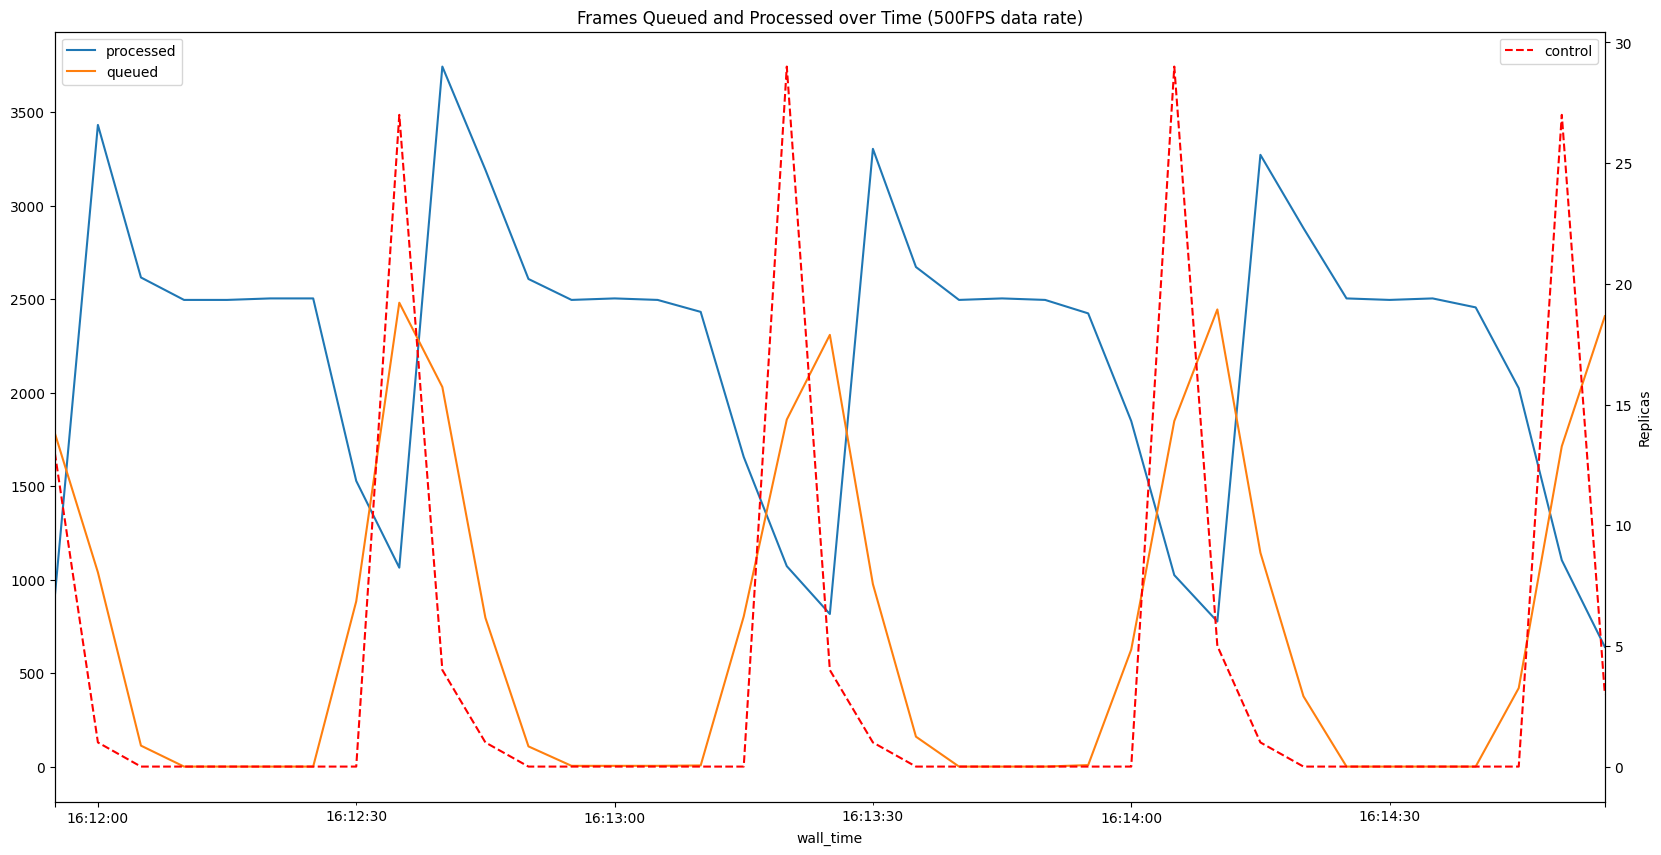

In [165]:

ax = framesprocessed_df.resample('5S').sum().plot(y='diff', title="Frames Processed", figsize=(20, 10), label='processed')
framesqueued_df.resample('5S').sum().plot(ax=ax, y='value', title="Frames Queued and Processed over Time (500FPS data rate)", figsize=(20, 10), label="queued")
ax2 = ax.twinx()
replica_df["value"].resample('5S').sum().plot(ax=ax2, color='r', linestyle='--', figsize=(20, 10), label="control")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Replicas')
# replica_df["value"].plot(ax=ax2, title="Replicas", figsize=(20, 10))
# total_diff_df = framesprocessed_df.resample('5S')['diff'].sum() + framesqueued_df.resample('5S')['value'].sum()
# total_diff_df.plot(y='diff', title="Total Frames Processed and Queued", figsize=(20, 10), ax=ax)